# Combinatorial library vs. KLIFS

## Aim of this notebook

In this notebook we want to compare the combinatorial library to the original KLIFS ligands, i.e. the ligands from which the fragment library originates from:

1. Which recombined ligands have exact matches in the original KLIFS ligands?
2. Which recombined ligands have substructure matches in the original KLIFS ligands?

**Note** that the combinatorial library is stored as `json` file (6.7M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here. In order to run this notebook, download data from zenodo as instructed in `../data/combinatorial_library/README.md`.

## Table of contents

1. Original ligands
2. Reduced fragment library
3. Exact matches
4. Substructure matches

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.core.display import HTML
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools

from kinfraglib import utils

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
HERE = Path(_dh[-1])

## 1. Original ligands

In [5]:
original_ligands = pd.read_json(HERE / '../../data/fragment_library/original_ligands.json')
original_ligands['ROMol'] = original_ligands.inchi.apply(Chem.MolFromInchi)
print(f'Number of original ligands: {original_ligands.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of original ligands: 3231


In [6]:
print(f'Number of deduplicated ligand structures (based on InChI): {original_ligands.drop_duplicates("inchi").shape[0]}')
print(f'Number of deduplicated ligand structures (based on SMILES): {original_ligands.drop_duplicates("smiles").shape[0]}')
print(f'Number of deduplicated ligands (based on ligand PDB): {original_ligands.drop_duplicates("ligand_pdb").shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of deduplicated ligand structures (based on InChI): 2744
Number of deduplicated ligand structures (based on SMILES): 2771
Number of deduplicated ligands (based on ligand PDB): 2721


In the original ligands dataset, some ligands appear multiple times. We did not deduplicate these ligands since their interactions to the kinase that they are co-crystallized with can show differences and therefore result in different fragments. 

**Side note**: Number of ligands in the deduplicated dataset differs, depending on the deduplication strategy (deduplicate based on InChIs, SMILES, or ligand PDB). 

## 2. Reduced fragment library

In [7]:
fragment_library = utils.read_fragment_library(HERE / '../../data/fragment_library_reduced/')
fragment_library.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

Loading this dataset is important in case we want to reconstruct a recombined ligand from its fragment and bond IDs.

## 3. Exact matches

Get recombined ligands in combinatorial library that have exact matches in the KLIFS original ligands.

### Load exact matches

,bond_ids,fragment_ids,original_exact,original_substructure,inchi,ROMol
0,"[[AP_7, FP_8], [SE_13, AP_8]]","[AP_15, FP_217, SE_1]",1,1,InChI=1S/C21H26N6O/c1-15(2)27-14-20(24-25-27)1...,
1,"[[AP_9, FP_14]]","[AP_0, FP_30]",1,1,InChI=1S/C17H18N6/c18-7-5-15(12-3-1-2-4-12)23-...,

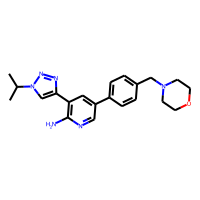
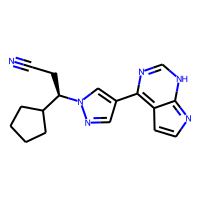

In [8]:
exact_matches = pd.read_json(HERE / '../../data/combinatorial_library/original_exact.json')[
    ['bond_ids', 'fragment_ids', 'original_exact', 'original_substructure', 'inchi']
]
exact_matches['ROMol'] = exact_matches.inchi.apply(Chem.MolFromInchi)
HTML(exact_matches.head(2).to_html(notebook=True))

In [9]:
print(f'Number of exact matches in KLIFS original ligands: {exact_matches.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of exact matches in KLIFS original ligands: 41


### Add structure data to exact matches

Merge combinatorial library data (fragment/bond IDs) with original ligands data (structure metadata)

In [10]:
# Get fragmentation details from exact_matches and kinase/structure details from orginal_ligands (keep both ROMol to check if the same)
exact_matches = pd.merge(
    exact_matches, 
    original_ligands.drop(['smiles', 'subpocket'], axis=1), 
    on='inchi', 
    how='left'
)
print(f'Number of exact matches in KLIFS original ligands (including duplicates): {exact_matches.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of exact matches in KLIFS original ligands (including duplicates): 65


Some exact matches appear multiple times in the original ligands.

### Construct recombined ligands (from fragment/bond IDs)

In [11]:
exact_matches.columns

Index(['bond_ids', 'fragment_ids', 'original_exact', 'original_substructure',
       'inchi', 'ROMol_x', 'complex_pdb', 'ligand_pdb', 'kinase', 'family',
       'group', 'alt', 'chain', 'ac_helix', 'klifs_id', 'ROMol_y'],
      dtype='object')

In [12]:
exact_matches[["fragment_ids", "bond_ids"]].head(10)

,fragment_ids,bond_ids
0,"[AP_15, FP_217, SE_1]","[[AP_7, FP_8], [SE_13, AP_8]]"
1,"[AP_0, FP_30]","[[AP_9, FP_14]]"
2,"[AP_0, FP_30]","[[AP_9, FP_14]]"
3,"[AP_0, FP_30]","[[AP_9, FP_14]]"
4,"[AP_0, FP_30]","[[AP_9, FP_14]]"
5,"[AP_28, FP_130]","[[FP_17, AP_10]]"
6,"[AP_28, FP_130]","[[FP_17, AP_10]]"
7,"[FP_95, AP_43]","[[FP_17, AP_6]]"
8,"[AP_16, FP_228, SE_48]","[[SE_10, AP_9], [FP_14, AP_8]]"
9,"[FP_189, AP_7]","[[AP_11, FP_13]]"


In [13]:
exact_matches_mols = [utils.construct_ligand(row.fragment_ids, row.bond_ids, fragment_library) for index, row in exact_matches.iterrows()]

In [14]:
exact_matches_legends = [f'{row.group} | {row.kinase} | {row.complex_pdb} | {row.ligand_pdb}' for index, row in exact_matches.iterrows()]

kinase group | kinase name | complex PDB | ligand PDB


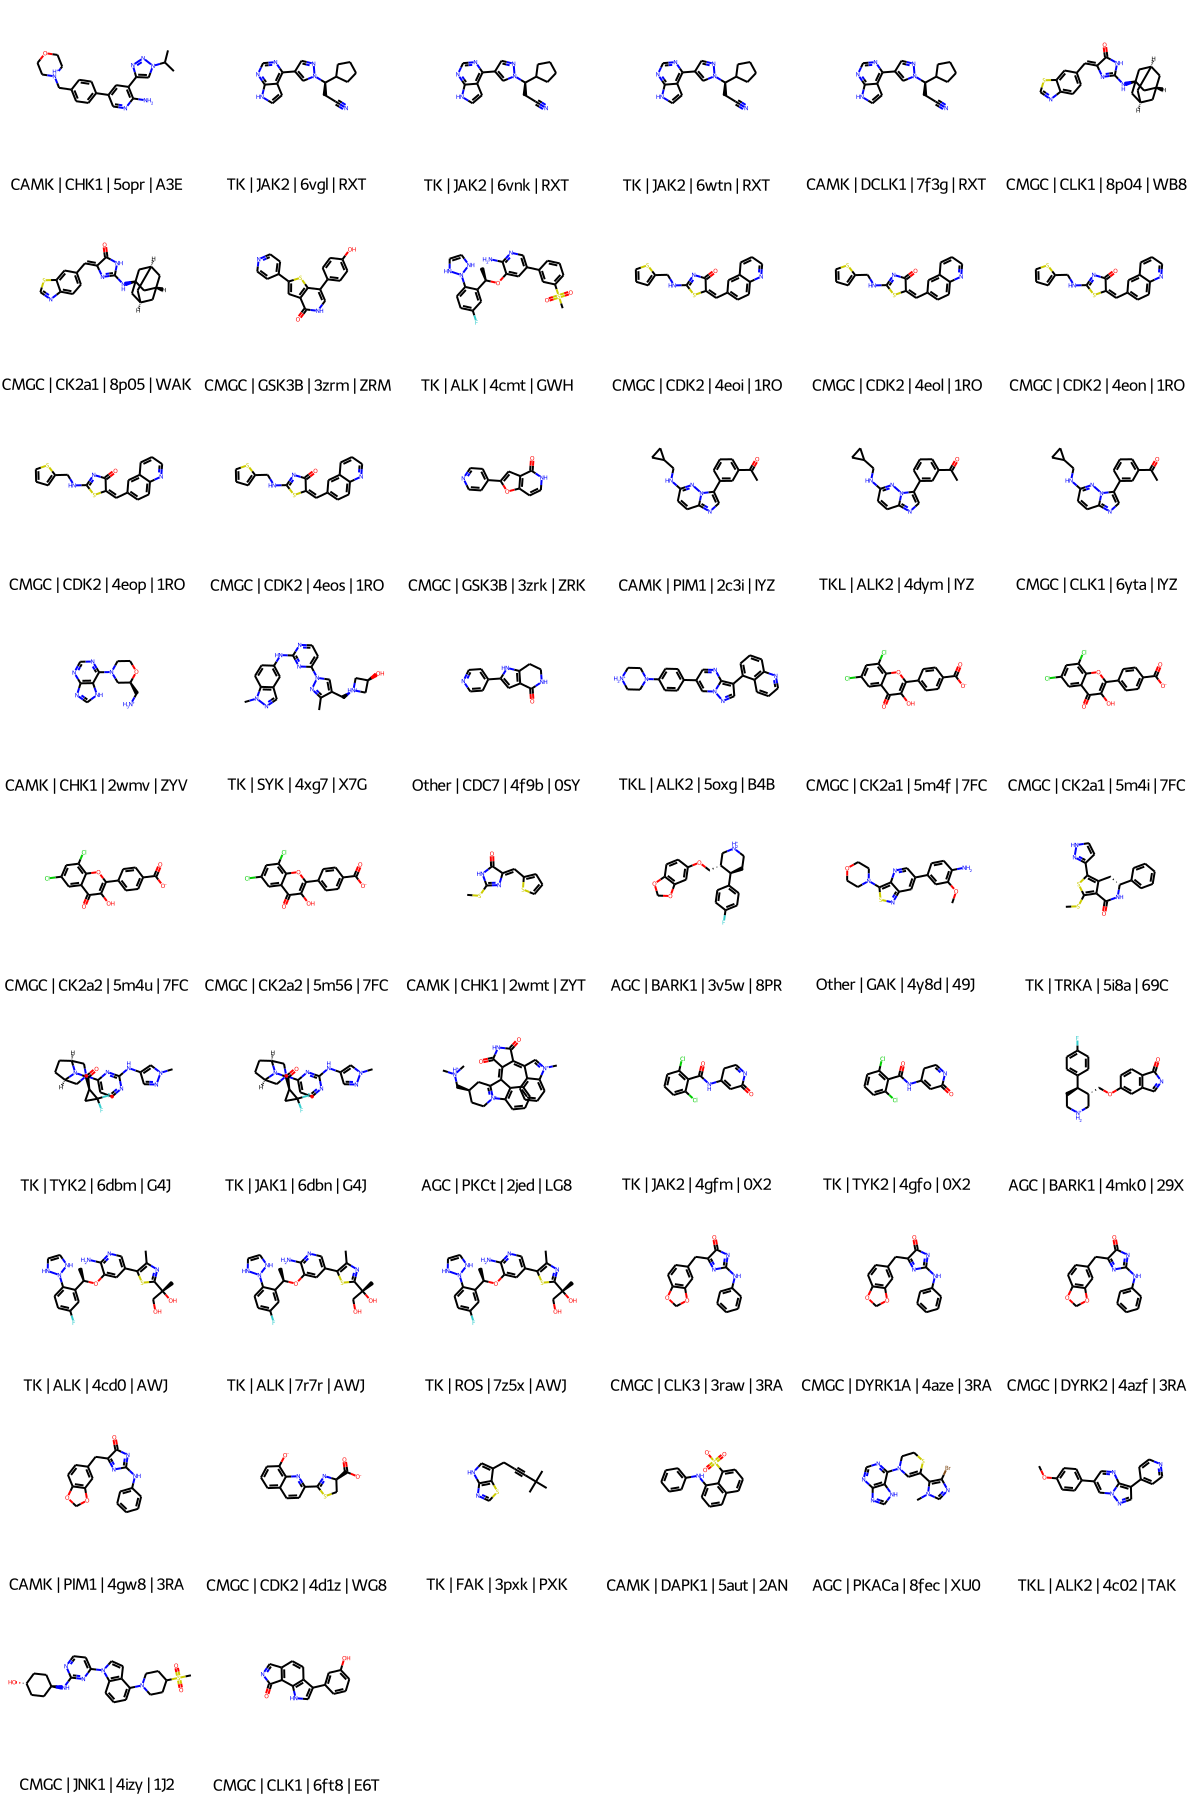

In [15]:
print(f'kinase group | kinase name | complex PDB | ligand PDB')

Draw.MolsToGridImage(
    mols=exact_matches_mols[:50], 
    legends=exact_matches_legends,
    molsPerRow=6
)

## 3. Substructure matches

Get recombined ligands in combinatorial library that have substructure matches in the KLIFS original ligands.

### Load substructure matches

In [16]:
substructure_matches = pd.read_json(HERE / '../../data/combinatorial_library/original_substructure.json')
substructure_matches['ROMol'] = substructure_matches.inchi.apply(Chem.MolFromInchi)

### Number of substructure matches

In [17]:
print(f'Number of substructure matches: {substructure_matches.shape[0]}')
# NBVAL_CHECK_OUTPUT

Number of substructure matches: 403


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi,ROMol
0,"[[AP_12, GA_3], [FP_6, AP_10], [SE_7, AP_11]]","[AP_12, FP_121, SE_27, GA_98]",1,1,1,1,26,0,"[CHEMBL399287, 0.91]",0,1,InChI=1S/C19H14N6S/c20-13-26-17-12-23-25-18(22...,
1,"[[FP_6, AP_10], [AP_11, SE_6], [AP_12, GA_5]]","[AP_12, GA_27, SE_68, FP_52]",1,1,1,1,26,0,"[CHEMBL1643206, 0.84]",0,1,InChI=1S/C17H20N8S/c1-11-6-16(26-24-11)23-15-7...,

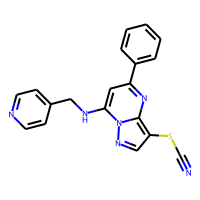
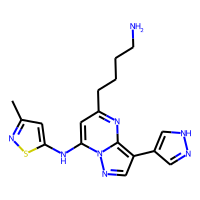

In [18]:
HTML(substructure_matches.head(2).to_html(notebook=True))

### Highlight recombined ligands as substructures in original ligands

In [19]:
def highlight_recombined_ligand_substructure_in_original_ligand(substructure_matches, original_ligands):
    """
    Highlight recombined ligands as substructures in original ligands.
    
    Parameters
    ----------
    substructure_matches : pandas.DataFrame
        Recombined ligands that have substructures in original ligands.
    original_ligands : pandas.DataFrame
        Original ligands.
    """

    substructure_details = []

    for i, recombined_ligand in substructure_matches.iterrows():
        for j, original_ligand in original_ligands.iterrows():

            template = original_ligand.ROMol
            pattern = recombined_ligand.ROMol
            match = template.HasSubstructMatch(pattern)

            if match:
                substructure = template.GetSubstructMatch(pattern)
                substructure_details.append([i, pattern, j, template, original_ligand.ligand_pdb])
                
    substructure_details = pd.DataFrame(
        substructure_details, 
        columns=[
            'recombined_ligand_index', 
            'recombined_ligand', 
            'original_ligand_index', 
            'original_ligand_with_substructure', 
            'ligand_pdb'
        ]
    )
    
    return substructure_details

In [20]:
# Takes 1-2 minutes
substructure_details = highlight_recombined_ligand_substructure_in_original_ligand(substructure_matches, original_ligands)

,recombined_ligand_index,recombined_ligand,original_ligand_index,original_ligand_with_substructure,ligand_pdb
0,0,,277,,3SC
1,1,,709,,MI5

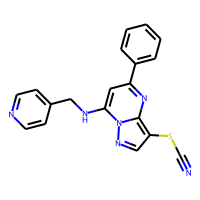
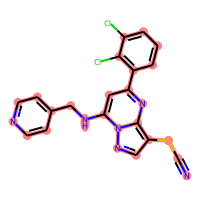
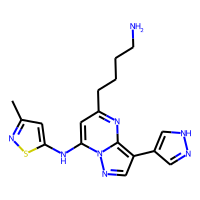
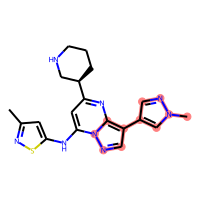

In [21]:
HTML(substructure_details.head(2).to_html(notebook=True))

### Number of original ligands having the same recombined ligand as substructure

In [22]:
recombined_in_original_size = substructure_details.groupby('recombined_ligand_index').size()

In [23]:
recombined_in_original_size.value_counts(sort=False).sort_index()
# NBVAL_CHECK_OUTPUT

1     157
2      50
3      29
4      30
5      19
6       2
7       9
8       5
9       7
10      7
11      2
13      1
14      4
15      5
17      1
18      1
20      1
21      2
22      1
26      2
28      2
30      1
38      1
41      1
46      1
61      1
73      1
dtype: int64

Text(0.5, 0, 'Number of original ligands having the same recombined ligand as substructure')

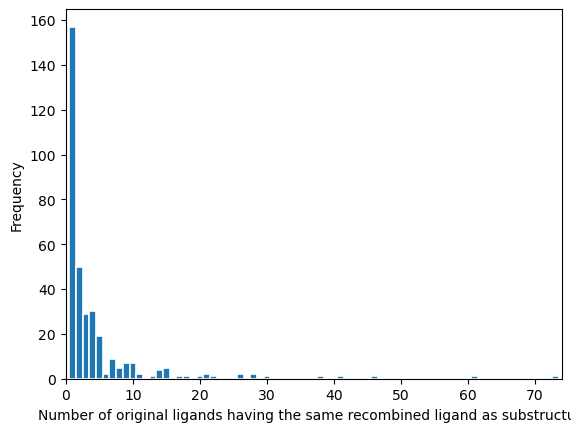

In [24]:
ax = recombined_in_original_size.plot(
    kind='hist', 
    bins=np.arange(recombined_in_original_size.max() + 2) - 0.5, 
    edgecolor='white', 
    linewidth=1.2,
    xlim=[0, recombined_in_original_size.max() + 1]
)
ax.set_xlabel('Number of original ligands having the same recombined ligand as substructure')

These recombined ligands that are often seen as substructure in the original ligands seem to represent an important structure in kinase-bound ligands and therefore are an interesting starting point for inhibitor design. Many of them are also very similar giving them even more weight.

### Draw recombined ligands that are most frequent substructures of original ligands

Number of original ligands with this substructure | recombined ligand index


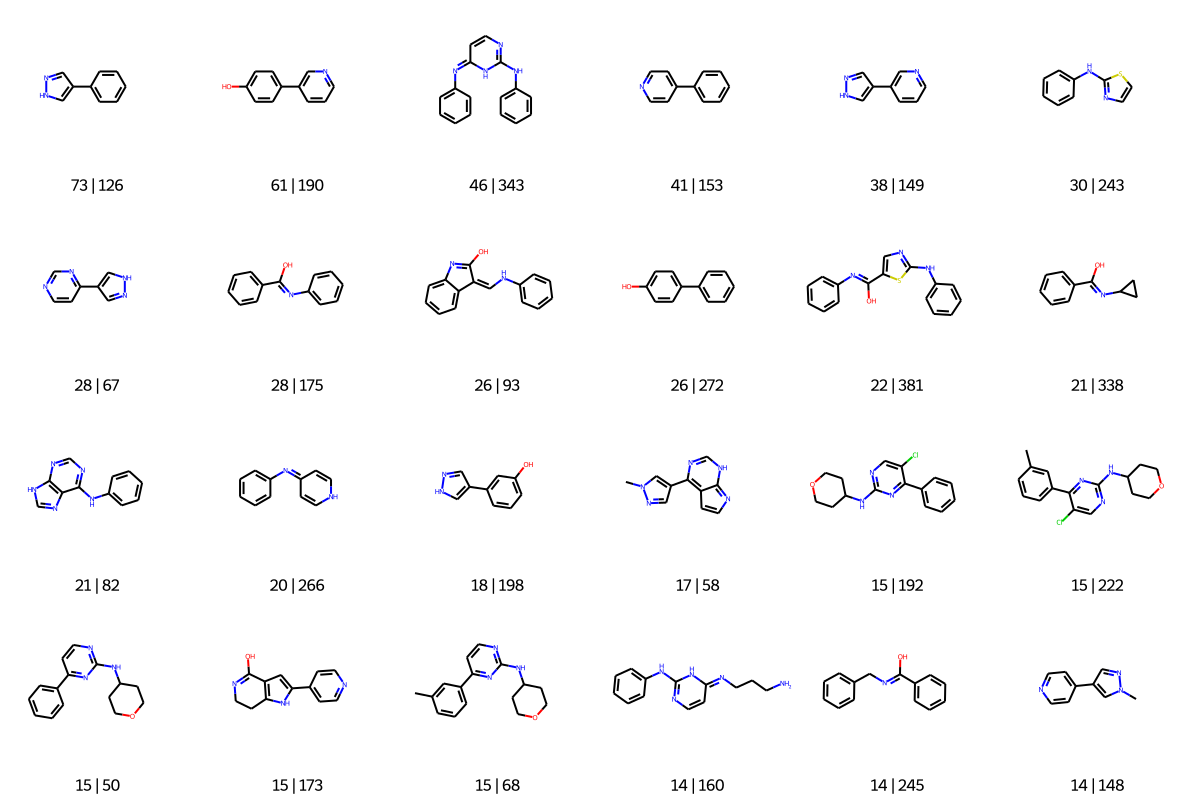

In [25]:
mols = []
legends = []

for index, size in recombined_in_original_size.sort_values(ascending=False).items():
    
    example_substructure = substructure_details[
        substructure_details.recombined_ligand_index == index
    ].iloc[0]
    
    mols.append(example_substructure.recombined_ligand)
    legends.append(f'{size} | {index}')
    
print(f'Number of original ligands with this substructure | recombined ligand index')
Draw.MolsToGridImage(mols=mols[:24], legends=legends, molsPerRow=6, maxMols=24)

Look at the fragments that were used to build this recombined ligand (first three ligands).

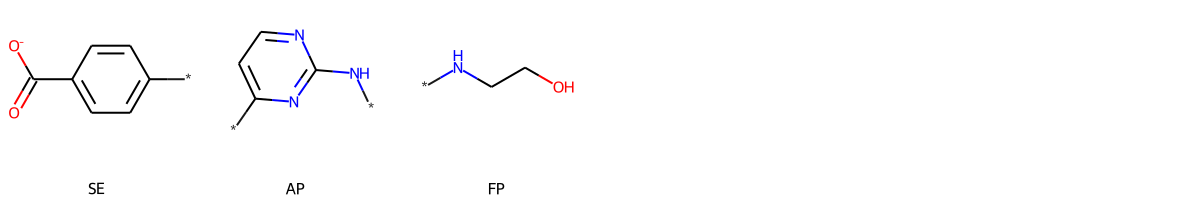

In [26]:
utils.draw_fragments_from_recombined_ligand(substructure_matches.iloc[283].fragment_ids, fragment_library)

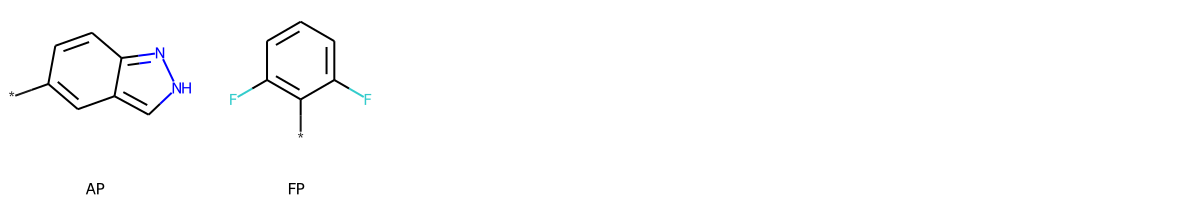

In [27]:
utils.draw_fragments_from_recombined_ligand(substructure_matches.iloc[43].fragment_ids, fragment_library)

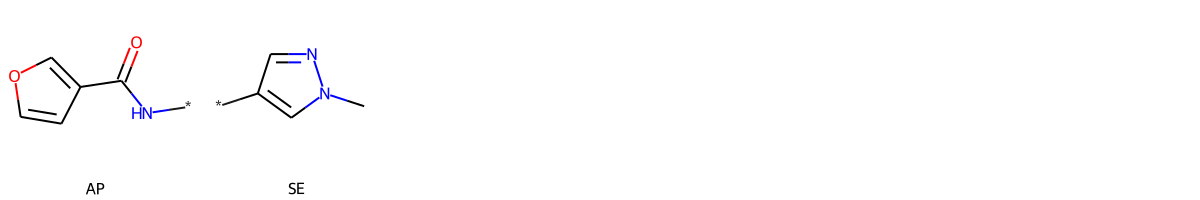

In [28]:
utils.draw_fragments_from_recombined_ligand(substructure_matches.iloc[117].fragment_ids, fragment_library)